<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week47.do.txt --no_mako -->
<!-- dom:TITLE: Week 47: Unsupervised learning (PCA and Clustering)  and Summary of Course -->

# Week 47: Unsupervised learning (PCA and Clustering)  and Summary of Course
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 22, 2022**

Copyright 1999-2022, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Overview of week 47

* **Thursday**: Dimensionality reduction and unsupervised learning: Principal Component analysis (PCA) and clustering

* **Friday**: PCA and clustering  and Summary of Course

1. We recommend highly the video on PCA by [Brunton and Kutz](http://www.databookuw.com/page-2/page-4/), see in particular the video of section 1.5. Repeating about the singular value discussion is also very useful as we will use this material as background.

2. [And another good video on PCA](https://www.youtube.com/watch?v=FgakZw6K1QQ)

3. [k-means clustering video](https://www.youtube.com/watch?v=4b5d3muPQmA)

**Reading recommendations:**

1. Geron's chapter 9 on PCA

2. Hastie et al Chapter 13 (sections 13.1-13.2 are the most relevant ones)

## Basic ideas of the Principal Component Analysis (PCA)

The principal component analysis deals with the problem of fitting a
low-dimensional affine subspace $S$ of dimension $d$ much smaller than
the total dimension $D$ of the problem at hand (our data
set). Mathematically it can be formulated as a statistical problem or
a geometric problem.  In our discussion of the theorem for the
classical PCA, we will stay with a statistical approach. 
Historically, the PCA was first formulated in a statistical setting in order to estimate the principal component of a multivariate random variable.

We have a data set defined by a design/feature matrix $\boldsymbol{X}$ (see below for its definition) 
* Each data point is determined by $p$ extrinsic (measurement) variables

* We may want to ask the following question: Are there fewer intrinsic variables (say $d << p$) that still approximately describe the data?

* If so, these intrinsic variables may tell us something important and finding these intrinsic variables is what dimension reduction methods do. 

A good read is for example [Vidal, Ma and Sastry](https://www.springer.com/gp/book/9780387878102).

## Introducing the Covariance and Correlation functions

Before we discuss the PCA theorem, we need to remind ourselves about
the definition of the covariance and the correlation function. These are quantities 

Suppose we have defined two vectors
$\hat{x}$ and $\hat{y}$ with $n$ elements each. The covariance matrix $\boldsymbol{C}$ is defined as

$$
\boldsymbol{C}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} \mathrm{cov}[\boldsymbol{x},\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{cov}[\boldsymbol{y},\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{y},\boldsymbol{y}] \\
             \end{bmatrix},
$$

where for example

$$
\mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] =\frac{1}{n} \sum_{i=0}^{n-1}(x_i- \overline{x})(y_i- \overline{y}).
$$

With this definition and recalling that the variance is defined as

$$
\mathrm{var}[\boldsymbol{x}]=\frac{1}{n} \sum_{i=0}^{n-1}(x_i- \overline{x})^2,
$$

we can rewrite the covariance matrix as

$$
\boldsymbol{C}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} \mathrm{var}[\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] & \mathrm{var}[\boldsymbol{y}] \\
             \end{bmatrix}.
$$

## More on the covariance
The covariance takes values between zero and infinity and may thus
lead to problems with loss of numerical precision for particularly
large values. It is common to scale the covariance matrix by
introducing instead the correlation matrix defined via the so-called
correlation function

$$
\mathrm{corr}[\boldsymbol{x},\boldsymbol{y}]=\frac{\mathrm{cov}[\boldsymbol{x},\boldsymbol{y}]}{\sqrt{\mathrm{var}[\boldsymbol{x}] \mathrm{var}[\boldsymbol{y}]}}.
$$

The correlation function is then given by values $\mathrm{corr}[\boldsymbol{x},\boldsymbol{y}]
\in [-1,1]$. This avoids eventual problems with too large values. We
can then define the correlation matrix for the two vectors $\boldsymbol{x}$
and $\boldsymbol{y}$ as

$$
\boldsymbol{K}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} 1 & \mathrm{corr}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{corr}[\boldsymbol{y},\boldsymbol{x}] & 1 \\
             \end{bmatrix},
$$

In the above example this is the function we constructed using **pandas**.

## Reminding ourselves about Linear Regression
In our derivation of the various regression algorithms like **Ordinary Least Squares** or **Ridge regression**
we defined the design/feature matrix $\boldsymbol{X}$ as

$$
\boldsymbol{X}=\begin{bmatrix}
x_{0,0} & x_{0,1} & x_{0,2}& \dots & \dots x_{0,p-1}\\
x_{1,0} & x_{1,1} & x_{1,2}& \dots & \dots x_{1,p-1}\\
x_{2,0} & x_{2,1} & x_{2,2}& \dots & \dots x_{2,p-1}\\
\dots & \dots & \dots & \dots \dots & \dots \\
x_{n-2,0} & x_{n-2,1} & x_{n-2,2}& \dots & \dots x_{n-2,p-1}\\
x_{n-1,0} & x_{n-1,1} & x_{n-1,2}& \dots & \dots x_{n-1,p-1}\\
\end{bmatrix},
$$

with $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$, with the predictors/features $p$  refering to the column numbers and the
entries $n$ being the row elements.
We can rewrite the design/feature matrix in terms of its column vectors as

$$
\boldsymbol{X}=\begin{bmatrix} \boldsymbol{x}_0 & \boldsymbol{x}_1 & \boldsymbol{x}_2 & \dots & \dots & \boldsymbol{x}_{p-1}\end{bmatrix},
$$

with a given vector

$$
\boldsymbol{x}_i^T = \begin{bmatrix}x_{0,i} & x_{1,i} & x_{2,i}& \dots & \dots x_{n-1,i}\end{bmatrix}.
$$

## Simple Example
With these definitions, we can now rewrite our $2\times 2$
correlation/covariance matrix in terms of a moe general design/feature
matrix $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$. This leads to a $p\times p$
covariance matrix for the vectors $\boldsymbol{x}_i$ with $i=0,1,\dots,p-1$

$$
\boldsymbol{C}[\boldsymbol{x}] = \begin{bmatrix}
\mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_1] & \mathrm{var}[\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots & \dots \\
\mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots & \dots  & \mathrm{var}[\boldsymbol{x}_{p-1}]\\
\end{bmatrix},
$$

## The Correlation Matrix

and the correlation matrix

$$
\boldsymbol{K}[\boldsymbol{x}] = \begin{bmatrix}
1 & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_2] & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_0] & 1  & \mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_2] & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_1] & 1 & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots & \dots \\
\mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots & \dots  & 1\\
\end{bmatrix},
$$

## Numpy Functionality

The Numpy function **np.cov** calculates the covariance elements using
the factor $1/(n-1)$ instead of $1/n$ since it assumes we do not have
the exact mean values.  The following simple function uses the
**np.vstack** function which takes each vector of dimension $1\times n$
and produces a $2\times n$ matrix $\boldsymbol{W}$

$$
\boldsymbol{W}^T = \begin{bmatrix} x_0 & y_0 \\
                          x_1 & y_1 \\
                          x_2 & y_2\\
                          \dots & \dots \\
                          x_{n-2} & y_{n-2}\\
                          x_{n-1} & y_{n-1} & 
             \end{bmatrix},
$$

which in turn is converted into into the $2\times 2$ covariance matrix
$\boldsymbol{C}$ via the Numpy function **np.cov()**. We note that we can also calculate
the mean value of each set of samples $\boldsymbol{x}$ etc using the Numpy
function **np.mean(x)**. We can also extract the eigenvalues of the
covariance matrix through the **np.linalg.eig()** function.

In [1]:
# Importing various packages
import numpy as np
n = 100
x = np.random.normal(size=n)
print(np.mean(x))
y = 4+3*x+np.random.normal(size=n)
print(np.mean(y))
W = np.vstack((x, y))
C = np.cov(W)
print(C)

## Correlation Matrix again

The previous example can be converted into the correlation matrix by
simply scaling the matrix elements with the variances.  We should also
subtract the mean values for each column. This leads to the following
code which sets up the correlations matrix for the previous example in
a more brute force way. Here we scale the mean values for each column of the design matrix, calculate the relevant mean values and variances and then finally set up the $2\times 2$ correlation matrix (since we have only two vectors).

In [2]:
import numpy as np
n = 100
# define two vectors                                                                                           
x = np.random.random(size=n)
y = 4+3*x+np.random.normal(size=n)
#scaling the x and y vectors                                                                                   
x = x - np.mean(x)
y = y - np.mean(y)
variance_x = np.sum(x@x)/n
variance_y = np.sum(y@y)/n
print(variance_x)
print(variance_y)
cov_xy = np.sum(x@y)/n
cov_xx = np.sum(x@x)/n
cov_yy = np.sum(y@y)/n
C = np.zeros((2,2))
C[0,0]= cov_xx/variance_x
C[1,1]= cov_yy/variance_y
C[0,1]= cov_xy/np.sqrt(variance_y*variance_x)
C[1,0]= C[0,1]
print(C)

We see that the matrix elements along the diagonal are one as they
should be and that the matrix is symmetric. Furthermore, diagonalizing
this matrix we easily see that it is a positive definite matrix.

The above procedure with **numpy** can be made more compact if we use **pandas**.

## Using Pandas

We whow here how we can set up the correlation matrix using **pandas**, as done in this simple code

In [3]:
import numpy as np
import pandas as pd
n = 10
x = np.random.normal(size=n)
x = x - np.mean(x)
y = 4+3*x+np.random.normal(size=n)
y = y - np.mean(y)
X = (np.vstack((x, y))).T
print(X)
Xpd = pd.DataFrame(X)
print(Xpd)
correlation_matrix = Xpd.corr()
print(correlation_matrix)

## And then the Franke Function

We expand this model to the Franke function discussed above.

In [4]:
# Common imports
import numpy as np
import pandas as pd


def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4


def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


# Making meshgrid of datapoints and compute Franke's function
n = 4
N = 100
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
z = FrankeFunction(x, y)
X = create_X(x, y, n=n)    

Xpd = pd.DataFrame(X)
# subtract the mean values and set up the covariance matrix
Xpd = Xpd - Xpd.mean()
covariance_matrix = Xpd.cov()
print(covariance_matrix)

We note here that the covariance is zero for the first rows and
columns since all matrix elements in the design matrix were set to one
(we are fitting the function in terms of a polynomial of degree $n$). We would however not include the intercept
and wee can simply
drop these elements and construct a correlation
matrix without them by centering our matrix elements by subtracting the mean of each column.

## Links with the Design Matrix

We can rewrite the covariance matrix in a more compact form in terms of the design/feature matrix $\boldsymbol{X}$ as

$$
\boldsymbol{C}[\boldsymbol{x}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}= \mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}].
$$

To see this let us simply look at a design matrix $\boldsymbol{X}\in {\mathbb{R}}^{2\times 2}$

$$
\boldsymbol{X}=\begin{bmatrix}
x_{00} & x_{01}\\
x_{10} & x_{11}\\
\end{bmatrix}=\begin{bmatrix}
\boldsymbol{x}_{0} & \boldsymbol{x}_{1}\\
\end{bmatrix}.
$$

## Computing the Expectation Values

If we then compute the expectation value

$$
\mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}=\begin{bmatrix}
x_{00}^2+x_{01}^2 & x_{00}x_{10}+x_{01}x_{11}\\
x_{10}x_{00}+x_{11}x_{01} & x_{10}^2+x_{11}^2\\
\end{bmatrix},
$$

which is just

$$
\boldsymbol{C}[\boldsymbol{x}_0,\boldsymbol{x}_1] = \boldsymbol{C}[\boldsymbol{x}]=\begin{bmatrix} \mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1] \\
                              \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1] \\
             \end{bmatrix},
$$

where we wrote $$\boldsymbol{C}[\boldsymbol{x}_0,\boldsymbol{x}_1] = \boldsymbol{C}[\boldsymbol{x}]$$ to indicate that this the covariance of the vectors $\boldsymbol{x}$ of the design/feature matrix $\boldsymbol{X}$.

It is easy to generalize this to a matrix $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$.

## Towards the PCA theorem

We have that the covariance matrix (the correlation matrix involves a simple rescaling) is given as

$$
\boldsymbol{C}[\boldsymbol{x}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}= \mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}].
$$

Let us now assume that we can perform a series of orthogonal transformations where we employ some orthogonal matrices $\boldsymbol{S}$.
These matrices are defined as $\boldsymbol{S}\in {\mathbb{R}}^{p\times p}$ and obey the orthogonality requirements $\boldsymbol{S}\boldsymbol{S}^T=\boldsymbol{S}^T\boldsymbol{S}=\boldsymbol{I}$. The matrix can be written out in terms of the column vectors $\boldsymbol{s}_i$ as $\boldsymbol{S}=[\boldsymbol{s}_0,\boldsymbol{s}_1,\dots,\boldsymbol{s}_{p-1}]$ and $\boldsymbol{s}_i \in {\mathbb{R}}^{p}$.

Assume also that there is a transformation $\boldsymbol{S}^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S}=\boldsymbol{C}[\boldsymbol{y}]$ such that the new matrix $\boldsymbol{C}[\boldsymbol{y}]$ is diagonal with elements $[\lambda_0,\lambda_1,\lambda_2,\dots,\lambda_{p-1}]$.  

That is we have

$$
\boldsymbol{C}[\boldsymbol{y}] = \mathbb{E}[\boldsymbol{S}^T\boldsymbol{X}^T\boldsymbol{X}T\boldsymbol{S}]=\boldsymbol{S}^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S},
$$

since the matrix $\boldsymbol{S}$ is not a data dependent matrix.   Multiplying with $\boldsymbol{S}$ from the left we have

$$
\boldsymbol{S}\boldsymbol{C}[\boldsymbol{y}] = \boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S},
$$

and since $\boldsymbol{C}[\boldsymbol{y}]$ is diagonal we have for a given eigenvalue $i$ of the covariance matrix that

$$
\boldsymbol{S}_i\lambda_i = \boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S}_i.
$$

## More on the PCA Theorem

In the derivation of the PCA theorem we will assume that the
eigenvalues are ordered in descending order, that is $\lambda_0 > \lambda_1 > \dots > \lambda_{p-1}$.

The eigenvalues tell us then how much we need to stretch the
corresponding eigenvectors. Dimensions with large eigenvalues have
thus large variations (large variance) and define therefore useful
dimensions. The data points are more spread out in the direction of
these eigenvectors.  Smaller eigenvalues mean on the other hand that
the corresponding eigenvectors are shrunk accordingly and the data
points are tightly bunched together and there is not much variation in
these specific directions. Hopefully then we could leave it out
dimensions where the eigenvalues are very small. If $p$ is very large,
we could then aim at reducing $p$ to $l << p$ and handle only $l$
features/predictors.

Here is how we would proceed in setting up the algorithm for the PCA, see also discussion below here. 
* Set up the datapoints for the design/feature matrix with the predictors/features $p$  referring to the column numbers and the entries $n$ being the row elements.

* Center the data by subtracting the mean value for each column. 

* Compute then the covariance/correlation matrix.

* Find the eigenpairs of the covariance matrix with eigenvalues $[\lambda_0,\lambda_1,\dots,\lambda_{p-1}]$ and eigenvectors $[\boldsymbol{s}_0,\boldsymbol{s}_1,\dots,\boldsymbol{s}_{p-1}]$.

* Order the eigenvalue (and the eigenvectors accordingly) in order of decreasing eigenvalues.

* Keep only those $l$ eigenvalues larger than a selected threshold value, discarding thus $p-l$ features since we expect small variations in the data here.

## A kind of Bird's view  on PCA

**Why do we maximize variance during Principal Component Analysis?**

Variance is a measure of the *variability* of the data you
have. Potentially the number of components is infinite, so you want to "squeeze" the most
information in each component of the finite set you build.

If, to exaggerate, you were to select a single principal component,
you would want it to account for the most variability possible: hence
the search for maximum variance, so that the one component collects
the most "uniqueness" from the data set.

Maximizing the component vector variances is the same as maximizing
the 'uniqueness' of those vectors. The vectors are as distant
from each other as possible (orthogonal to each other).

Take for example a situation where you have 2 lines that are
orthogonal in a 3D space. You can capture the environment much more
completely with those orthogonal lines than 2 lines that are parallel
(or nearly parallel). When applied to very high dimensional states
using very few vectors, this becomes a much more important
relationship among the vectors to maintain. In a linear algebra sense
you want independent rows to be produced by PCA, otherwise some of
those rows will be redundant.

## Writing our own PCA code

We will use a simple example first with two-dimensional data
drawn from a multivariate normal distribution with the following mean and covariance matrix (we have fixed these quantities but will play around with them below):

$$
\mu = (-1,2) \qquad \Sigma = \begin{bmatrix} 4 & 2 \\
2 & 2
\end{bmatrix}
$$

Note that the mean refers to each column of data. 
We will generate $n = 10000$ points $X = \{ x_1, \ldots, x_N \}$ from
this distribution, and store them in the $1000 \times 2$ matrix $\boldsymbol{X}$. This is our design matrix where we have forced the covariance and mean values to take specific values.

## Implementing it
The following Python code aids in setting up the data and writing out the design matrix.
Note that the function **multivariate** returns also the covariance discussed above and that it is defined by dividing by $n-1$ instead of $n$.

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
n = 10000
mean = (-1, 2)
cov = [[20, 0.2], [0.2, 0.2]]
X = np.random.multivariate_normal(mean, cov, n)

Now we are going to implement the PCA algorithm. We will break it down into various substeps.

## First Step

The first step of PCA is to compute the sample mean of the data and use it to center the data. Recall that the sample mean is

$$
\mu_n = \frac{1}{n} \sum_{i=1}^n x_i
$$

and the mean-centered data $\bar{X} = \{ \bar{x}_1, \ldots, \bar{x}_n \}$ takes the form

$$
\bar{x}_i = x_i - \mu_n.
$$

When you are done with these steps, print out $\mu_n$ to verify it is
close to $\mu$ and plot your mean centered data to verify it is
centered at the origin! 
The following code elements perform these operations using **pandas** or using our own functionality for doing so. The latter, using **numpy** is rather simple through the **mean()** function.

In [11]:
df = pd.DataFrame(X)
# Pandas does the centering for us
df = df -df.mean()
# we center it ourselves
X_centered = X - X.mean(axis=0)

## Scaling
Alternatively, we could use the functions we discussed
earlier for scaling the data set.  That is, we could have used the
**StandardScaler** function in **Scikit-Learn**, a function which ensures
that for each feature/predictor we study the mean value is zero and
the variance is one (every column in the design/feature matrix).  You
would then not get the same results, since we divide by the
variance. The diagonal covariance matrix elements will then be one,
while the non-diagonal ones need to be divided by $2\sqrt{2}$ for our
specific case.

## Centered Data

Now we are going to use the mean centered data to compute the sample covariance of the data by using the following equation

$$
\Sigma_n = \frac{1}{n-1} \sum_{i=1}^n \bar{x}_i^T \bar{x}_i = \frac{1}{n-1} \sum_{i=1}^n (x_i - \mu_n)^T (x_i - \mu_n)
$$

where the data points $x_i \in \mathbb{R}^p$ (here in this example $p = 2$) are column vectors and $x^T$ is the transpose of $x$.
We can write our own code or simply use either the functionaly of **numpy** or that of **pandas**, as follows

In [12]:
print(df.cov())
print(np.cov(X_centered.T))

           0         1
0  19.993702  0.184113
1   0.184113  0.198691
[[19.99370195  0.18411281]
 [ 0.18411281  0.19869054]]


Note that the way we define the covariance matrix here has a factor $n-1$ instead of $n$. This is included in the **cov()** function by **numpy** and **pandas**. 
Our own code here is not very elegant and asks for obvious improvements. It is tailored to this specific $2\times 2$ covariance matrix.

Centered covariance using own code
[[19.99370195  0.18411281]
 [ 0.18411281  0.19869054]]


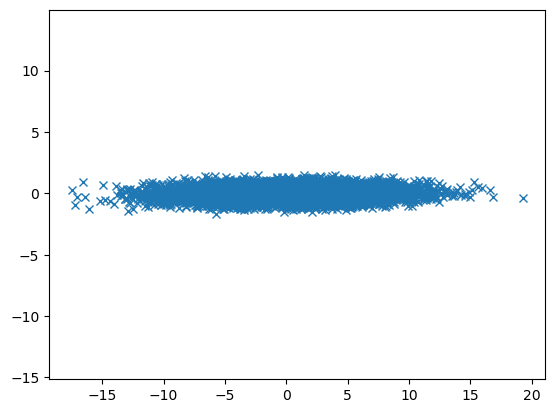

In [13]:
# extract the relevant columns from the centered design matrix of dim n x 2
x = X_centered[:,0]
y = X_centered[:,1]
Cov = np.zeros((2,2))
Cov[0,1] = np.sum(x.T@y)/(n-1.0)
Cov[0,0] = np.sum(x.T@x)/(n-1.0)
Cov[1,1] = np.sum(y.T@y)/(n-1.0)
Cov[1,0]= Cov[0,1]
print("Centered covariance using own code")
print(Cov)
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

## Exploring

Depending on the number of points $n$, we will get results that are close to the covariance values defined above.
The plot shows how the data are clustered around a line with slope close to one. Is this expected?  Try to change the covariance and the mean values. For example, try to make the variance of the first element much larger than that of the second diagonal element. Try also to shrink the covariance  (the non-diagonal elements) and see how the data points are distributed.

## Diagonalize the sample covariance matrix to obtain the principal components

Now we are ready to solve for the principal components! To do so we
diagonalize the sample covariance matrix $\Sigma$. We can use the
function **np.linalg.eig** to do so. It will return the eigenvalues and
eigenvectors of $\Sigma$. Once we have these we can perform the 
following tasks:

* We compute the percentage of the total variance captured by the first principal component

* We plot the mean centered data and lines along the first and second principal components

* Then we project the mean centered data onto the first and second principal components, and plot the projected data. 

* Finally, we approximate the data as

$$
x_i \approx \tilde{x}_i = \mu_n + \langle x_i, v_0 \rangle v_0
$$

where $v_0$ is the first principal component.

## Collecting all Steps

Collecting all these steps we can write our own PCA function and
compare this with the functionality included in **Scikit-Learn**.  

The code here outlines some of the elements we could include in the
analysis. Feel free to extend upon this in order to address the above
questions.

In [9]:
# diagonalize and obtain eigenvalues, not necessarily sorted
EigValues, EigVectors = np.linalg.eig(Cov)
# sort eigenvectors and eigenvalues
#permute = EigValues.argsort()
#EigValues = EigValues[permute]
#EigVectors = EigVectors[:,permute]
print("Eigenvalues of Covariance matrix")
for i in range(2):
    print(EigValues[i])
FirstEigvector = EigVectors[:,0]
SecondEigvector = EigVectors[:,1]
print("First eigenvector")
print(FirstEigvector)
print("Second eigenvector")
print(SecondEigvector)
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2Dsl = pca.fit_transform(X)
print("Eigenvector of largest eigenvalue")
print(pca.components_.T[:, 0])

This code does not contain all the above elements, but it shows how we can use **Scikit-Learn** to extract the eigenvector which corresponds to the largest eigenvalue. Try to address the questions we pose before the above code.  Try also to change the values of the covariance matrix by making one of the diagonal elements much larger than the other. What do you observe then?

## Classical PCA Theorem

We assume now that we have a design matrix $\boldsymbol{X}$ which has been
centered as discussed above. For the sake of simplicity we skip the
overline symbol. The matrix is defined in terms of the various column
vectors $[\boldsymbol{x}_0,\boldsymbol{x}_1,\dots, \boldsymbol{x}_{p-1}]$ each with dimension
$\boldsymbol{x}\in {\mathbb{R}}^{n}$.

The PCA theorem states that minimizing the above reconstruction error
corresponds to setting $\boldsymbol{W}=\boldsymbol{S}$, the orthogonal matrix which
diagonalizes the empirical covariance(correlation) matrix. The optimal
low-dimensional encoding of the data is then given by a set of vectors
$\boldsymbol{z}_i$ with at most $l$ vectors, with $l << p$, defined by the
orthogonal projection of the data onto the columns spanned by the
eigenvectors of the covariance(correlations matrix).

## The PCA Theorem

To show the PCA theorem let us start with the assumption that there is one vector $\boldsymbol{s}_0$ which corresponds to a solution which minimized the reconstruction error $J$. This is an orthogonal vector. It means that we now approximate the reconstruction error in terms of $\boldsymbol{w}_0$ and $\boldsymbol{z}_0$ as

We are almost there, we have obtained a relation between minimizing
the reconstruction error and the variance and the covariance
matrix. Minimizing the error is equivalent to maximizing the variance
of the projected data.

We could trivially maximize the variance of the projection (and
thereby minimize the error in the reconstruction function) by letting
the norm-2 of $\boldsymbol{w}_0$ go to infinity. However, this norm since we
want the matrix $\boldsymbol{W}$ to be an orthogonal matrix, is constrained by
$\vert\vert \boldsymbol{w}_0 \vert\vert_2^2=1$. Imposing this condition via a
Lagrange multiplier we can then in turn maximize

$$
J(\boldsymbol{w}_0)= \boldsymbol{w}_0^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0+\lambda_0(1-\boldsymbol{w}_0^T\boldsymbol{w}_0).
$$

Taking the derivative with respect to $\boldsymbol{w}_0$ we obtain

$$
\frac{\partial J(\boldsymbol{w}_0)}{\partial \boldsymbol{w}_0}= 2\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0-2\lambda_0\boldsymbol{w}_0=0,
$$

meaning that

$$
\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0=\lambda_0\boldsymbol{w}_0.
$$

**The direction that maximizes the variance (or minimizes the construction error) is an eigenvector of the covariance matrix**! If we left multiply with $\boldsymbol{w}_0^T$ we have the variance of the projected data is

$$
\boldsymbol{w}_0^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0=\lambda_0.
$$

If we want to maximize the variance (minimize the construction error)
we simply pick the eigenvector of the covariance matrix with the
largest eigenvalue. This establishes the link between the minimization
of the reconstruction function $J$ in terms of an orthogonal matrix
and the maximization of the variance and thereby the covariance of our
observations encoded in the design/feature matrix $\boldsymbol{X}$.

The proof
for the other eigenvectors $\boldsymbol{w}_1,\boldsymbol{w}_2,\dots$ can be
established by applying the above arguments and using the fact that
our basis of eigenvectors is orthogonal, see [Murphy chapter
12.2](https://mitpress.mit.edu/books/machine-learning-1).  The
discussion in chapter 12.2 of Murphy's text has also a nice link with
the Singular Value Decomposition theorem. For categorical data, see
chapter 12.4 and discussion therein.

For more details, see for example [Vidal, Ma and Sastry, chapter 2](https://www.springer.com/gp/book/9780387878102).

## Geometric Interpretation and link with Singular Value Decomposition

For a detailed demonstration of the geometric interpretation, see [Vidal, Ma and Sastry, section 2.1.2](https://www.springer.com/gp/book/9780387878102).

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm.
First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

The following Python code uses NumPy’s **svd()** function to obtain all the principal components of the
training set, then extracts the first two principal components. First we center the data using either **pandas** or our own code

In [10]:
import numpy as np
import pandas as pd
from IPython.display import display
np.random.seed(100)
# setting up a 10 x 5 vanilla matrix 
rows = 10
cols = 5
X = np.random.randn(rows,cols)
df = pd.DataFrame(X)
# Pandas does the centering for us
df = df -df.mean()
display(df)

# we center it ourselves
X_centered = X - X.mean(axis=0)
# Then check the difference between pandas and our own set up
print(X_centered-df)
#Now we do an SVD
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)
print(X2D)

PCA assumes that the dataset is centered around the origin. Scikit-Learn’s PCA classes take care of centering
the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t
forget to center the data first.

Once you have identified all the principal components, you can reduce the dimensionality of the dataset
down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components.
Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

In [11]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

## PCA and scikit-learn

Scikit-Learn’s PCA class implements PCA using SVD decomposition just like we did before. The
following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note
that it automatically takes care of centering the data):

In [12]:
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print(X2D)

After fitting the PCA transformer to the dataset, you can access the principal components using the
components variable (note that it contains the PCs as horizontal vectors, so, for example, the first
principal component is equal to

In [13]:
pca.components_.T[:, 0]

Another very useful piece of information is the explained variance ratio of each principal component,
available via the $explained\_variance\_ratio$ variable. It indicates the proportion of the dataset’s
variance that lies along the axis of each principal component.

## Back to the Cancer Data
We can now repeat the above but applied to real data, in this case our breast cancer data.
Here we compute performance scores on the training data using logistic regression.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Train set accuracy from Logistic Regression: {:.2f}".format(logreg.score(X_train,y_train)))
# We scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Then perform again a log reg fit
logreg.fit(X_train_scaled, y_train)
print("Train set accuracy scaled data: {:.2f}".format(logreg.score(X_train_scaled,y_train)))
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D_train = pca.fit_transform(X_train_scaled)
# and finally compute the log reg fit and the score on the training data	
logreg.fit(X2D_train,y_train)
print("Train set accuracy scaled and PCA data: {:.2f}".format(logreg.score(X2D_train,y_train)))

We see that our training data after the PCA decomposition has a performance similar to the non-scaled data. 

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to
choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).
Unless, of course, you are reducing dimensionality for data visualization — in that case you will
generally want to reduce the dimensionality down to 2 or 3.
The following code computes PCA without reducing dimensionality, then computes the minimum number
of dimensions required to preserve 95% of the training set’s variance:

In [15]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You could then set $n\_components=d$ and run PCA again. However, there is a much better option: instead
of specifying the number of principal components you want to preserve, you can set $n\_components$ to be
a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

## Incremental PCA

One problem with the preceding implementation of PCA is that it requires the whole training set to fit in
memory in order for the SVD algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have
been developed: you can split the training set into mini-batches and feed an IPCA algorithm one minibatch
at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new
instances arrive).

### Randomized PCA

Scikit-Learn offers yet another option to perform PCA, called Randomized PCA. This is a stochastic
algorithm that quickly finds an approximation of the first d principal components. Its computational
complexity is $O(m \times d^2)+O(d^3)$, instead of $O(m \times n^2) + O(n^3)$, so it is dramatically faster than the
previous algorithms when $d$ is much smaller than $n$.

### Kernel PCA

The kernel trick is a mathematical technique that implicitly maps instances into a
very high-dimensional space (called the feature space), enabling nonlinear classification and regression
with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature
space corresponds to a complex nonlinear decision boundary in the original space.
It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear
projections for dimensionality reduction. This is called Kernel PCA (kPCA). It is often good at
preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a
twisted manifold.
For example, the following code uses Scikit-Learn’s KernelPCA class to perform kPCA with an

In [17]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

## Other techniques

There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn.

Here are some of the most popular:
* **Multidimensional Scaling (MDS)** reduces dimensionality while trying to preserve the distances between the instances.

* **Isomap** creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

* **t-Distributed Stochastic Neighbor Embedding** (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

* Linear Discriminant Analysis (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as a Support Vector Machine (SVM) classifier discussed in the SVM lectures.

## Clustering and Unsupervised Learning

In general terms cluster analysis, or clustering, is the task of grouping a
data-set into different distinct categories based on some measure of equality of
the data. This measure is often referred to as a **metric** or **similarity
measure** in the literature (note: sometimes we deal with a **dissimilarity
measure** instead). Usually, these metrics are formulated as some kind of
distance function between points in a high-dimensional space.

The simplest, and also the most
common is the **Euclidean distance**.

## Basic Idea of the $k$-means Clustering Algorithm

The simplest of all clustering algorithms is the  **k-means algorithm**
, sometimes also referred to as *Lloyds algorithm*. It is the simplest and also
the most common. From its simplicity it obtains both strengths and weaknesses.
These will be discussed in more detail later. The $k$-means algorithm is a
**centroid based** clustering algorithm.

## The $k$-means Algorithm

Assume, we are given $n$ data points and we wish to split the data into $K < n$
different categories, or clusters. We label each cluster by an integer

$$
k\in\{1, \cdots, K \}.
$$

In the basic k-means algorithm each point is assigned to only
one cluster $k$, and these assignments are *non-injective* i.e. many-to-one. We
can think of these mappings as an encoder $k = C(i)$, which assigns the $i$-th
data-point $\bf x_i$ to the $k$-th cluster.

$k$-means algorithm in words:
1. We start with guesses / random initializations of our $k$ cluster centers/centroids

2. For each centroid the points that are most similar are identified

3. Then we move / replace each centroid with a coordinate average of all the points that were assigned to that centroid.

4. Iterate 2-3 until the centroids no longer move (to some tolerance)

## Basic Math of the $k$-means Algorithm

We assume we have $n$ data-points

<!-- Equation labels as ordinary links -->
<div id="eq:kmeanspoints"></div>

$$
\begin{equation}\label{eq:kmeanspoints} \tag{1}
  \boldsymbol{x_i}  = \{x_{i, 1}, \cdots, x_{i, p}\}\in\mathbb{R}^p.
\end{equation}
$$

which we wish to group into $K < n$ clusters. For our dissimilarity measure we
use the *squared Euclidean distance*

<!-- Equation labels as ordinary links -->
<div id="eq:squaredeuclidean"></div>

$$
\begin{equation}\label{eq:squaredeuclidean} \tag{2}
  d(\boldsymbol{x_i}, \boldsymbol{x_i'}) = \sum_{j=1}^p(x_{ij} - x_{i'j})^2
                         = ||\boldsymbol{x_i} - \boldsymbol{x_{i'}}||^2
\end{equation}
$$

## Within Cluster Point Scatter

We define the so called *within-cluster point scatter* which gives us a
measure of how close each data point assigned to the same cluster tends to be to
the all the others.

<!-- Equation labels as ordinary links -->
<div id="eq:withincluster"></div>

$$
\begin{equation}\label{eq:withincluster} \tag{3}
  W(C) = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}
          \sum_{C(i')=k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}}) =
          \sum_{k=1}^KN_k\sum_{C(i)=k}||\boldsymbol{x_i} - \boldsymbol{\overline{x_k}}||^2
\end{equation}
$$

where $\boldsymbol{\overline{x_k}}$ is the mean vector associated with the $k$-th
cluster, and $N_k = \sum_{i=1}^nI(C(i) = k)$, where the $I()$ notation is
similar to the Kronecker delta (*Commonly used in statistics, it just means that
when $i = k$ we have the encoder $C(i)$*). In other words,  the within-cluster
scatter measures the compactness of each cluster with respect to the data points
assigned to each cluster. This is the quantity that the $k$-means algorithm aims
to minimize. We refer to this quantity $W(C)$ as the within cluster scatter
because of its relation to the *total scatter*.

## More Details

We have

<!-- Equation labels as ordinary links -->
<div id="eq:totalscatter"></div>

$$
\begin{equation}\label{eq:totalscatter} \tag{4}
  T = W(C) + B(C) = \frac{1}{2}\sum_{i=1}^n
                    \sum_{i'=1}^nd(\boldsymbol{x_i}, \boldsymbol{x_{i'}})
                  = \frac{1}{2}\sum_{k=1}^K\sum_{C(i)=k}
                    \Big(\sum_{C(i') = k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}})
                  + \sum_{C(i')\neq k}d(\boldsymbol{x_i}, \boldsymbol{x_{i'}})\Big).
\end{equation}
$$

This is a quantity that is conserved throughout the $k$-means algorithm. It can
be thought of as the total amount of information in the data, and it is composed
of the aforementioned within-cluster scatter and the *between-cluster scatter*
$B(C)$. In methods such as principle component analysis the total scatter is not
conserved.

## Total Cluster Variance
Given a cluster mean $\boldsymbol{m_k}$ we define the **total cluster variance**

<!-- Equation labels as ordinary links -->
<div id="eq:totalclustervariance"></div>

$$
\begin{equation}\label{eq:totalclustervariance} \tag{5}
  \min_{C, \{\boldsymbol{m_k}\}_1^K}\sum_{k=1}^KN_k\sum||\boldsymbol{x_i} - \boldsymbol{m_k}||^2
\end{equation}
$$

Now we have all the pieces necessary to formally revisit the $k$-means algorithm.

## The $k$-means Clustering Algorithm

The $k$-means clustering algorithm goes as follows 

1. For a given cluster assignment $C$, and $k$ cluster means $\left\{m_1, \cdots, m_k\right\}$. We minimize the total cluster variance with respect to the cluster means $\{m_k\}$ yielding the means of the currently assigned clusters.

2. Given a current set of $k$ means $\{m_k\}$ the total cluster variance is minimized by assigning each observation to the closest (current) cluster mean. That is $$C(i) = \underset{1\leq k\leq K}{\mathrm{argmin}} ||\boldsymbol{x_i} - \boldsymbol{m_k}||^2$$

3. Steps 1 and 2 are repeated until the assignments do not change.

## Summarizing

1. Before we start we specify a number $k$ which is the number of clusters we want to try to separate our data into.

2. We initially choose $k$ random data points in our data as our initial centroids, *or means* (this is where the name comes from).

3. Assign each data point to their closest centroid, based on the squared Euclidean distance.

4. For each of the $k$ cluster we update the centroid by calculating new mean values for all the data points in the cluster.

5. Iteratively minimize the within cluster scatter by performing steps (3, 4) until the new assignments stop changing (can be to some tolerance) or until a maximum number of iterations have passed.

## Writing our own Code, the Data Set

Let us now program the most basic version of the algorithm using nothing but
Python with numpy arrays. This code is kept intentionally simple to gradually
progress our understanding. There is no vectorization of any kind, and even most
helper functions are not utilized.

We need first a dataset to do our cluster analysis on. In our case
this is a plain *vanilla* data set using random numbers using a
Gaussian distribution.

In [18]:
import time
import numpy as np
import tensorflow as tf
from matplotlib import image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display

np.random.seed(2021)

Next we define functions, for ease of use later, to generate Gaussians and to
set up our toy data set.

In [19]:
def gaussian_points(dim=2, n_points=1000, mean_vector=np.array([0, 0]),
                    sample_variance=1):
    """
    Very simple custom function to generate gaussian distributed point clusters
    with variable dimension, number of points, means in each direction
    (must match dim) and sample variance.

    Inputs:
        dim (int)
        n_points (int)
        mean_vector (np.array) (where index 0 is x, index 1 is y etc.)
        sample_variance (float)

    Returns:
        data (np.array): with dimensions (dim x n_points)
    """

    mean_matrix = np.zeros(dim) + mean_vector
    covariance_matrix = np.eye(dim) * sample_variance
    data = np.random.multivariate_normal(mean_matrix, covariance_matrix,
                                    n_points)
    return data



def generate_simple_clustering_dataset(dim=2, n_points=1000, plotting=True,
                                    return_data=True):
    """
    Toy model to illustrate k-means clustering
    """

    data1 = gaussian_points(mean_vector=np.array([5, 5]))
    data2 = gaussian_points()
    data3 = gaussian_points(mean_vector=np.array([1, 4.5]))
    data4 = gaussian_points(mean_vector=np.array([5, 1]))
    data = np.concatenate((data1, data2, data3, data4), axis=0)

    if plotting:
        fig, ax = plt.subplots()
        ax.scatter(data[:, 0], data[:, 1], alpha=0.2)
        ax.set_title('Toy Model Dataset')
        plt.show()


    if return_data:
        return data


data = generate_simple_clustering_dataset()

## Implementing the $k$-means Algorithm

With the above dataset we start
implementing the $k$-means algorithm.

In [20]:

n_samples, dimensions = data.shape
n_clusters = 4

# we randomly initialize our centroids
np.random.seed(2021)
centroids = data[np.random.choice(n_samples, n_clusters, replace=False), :]
distances = np.zeros((n_samples, n_clusters))

# first we need to calculate the distance to each centroid from our data
for k in range(n_clusters):
    for n in range(n_samples):
        dist = 0
        for d in range(dimensions):
            dist += np.abs(data[n, d] - centroids[k, d])**2
            distances[n, k] = dist

# we initialize an array to keep track of to which cluster each point belongs
# the way we set it up here the index tracks which point and the value which
# cluster the point belongs to
cluster_labels = np.zeros(n_samples, dtype='int')

# next we loop through our samples and for every point assign it to the cluster
# to which it has the smallest distance to
for n in range(n_samples):
    # tracking variables (all of this is basically just an argmin)
    smallest = 1e10
    smallest_row_index = 1e10
    for k in range(n_clusters):
        if distances[n, k] < smallest:
            smallest = distances[n, k]
            smallest_row_index = k

    cluster_labels[n] = smallest_row_index

## Plotting

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
unique_cluster_labels = np.unique(cluster_labels)
for i in unique_cluster_labels:
    ax.scatter(data[cluster_labels == i, 0],
               data[cluster_labels == i, 1],
               label = i,
               alpha = 0.2)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black')

ax.set_title("First Grouping of Points to Centroids")

plt.show()

So what do we have so far? We have 'picked' $k$ centroids at random from our
data points. There are other ways of more intelligently choosing their
initializations, however for our purposes randomly is fine. Then we have
initialized an array 'distances' which holds the information of the distance,
*or dissimilarity*, of every point to of our centroids. Finally, we have
initialized an array 'cluster_labels' which according to our distances array
holds the information of to which centroid every point is assigned. This was the
first pass of our algorithm. Essentially, all we need to do now is repeat the
distance and assignment steps above until we have reached a desired convergence
or a maximum amount of iterations.

## Continuing

In [22]:

max_iterations = 100
tolerance = 1e-8

for iteration in range(max_iterations):
    prev_centroids = centroids.copy()
    for k in range(n_clusters):
        # this array will be used to update our centroid positions
        vector_mean = np.zeros(dimensions)
        mean_divisor = 0
        for n in range(n_samples):
            if cluster_labels[n] == k:
                vector_mean += data[n, :]
                mean_divisor += 1

        # update according to the k means
        centroids[k, :] = vector_mean / mean_divisor

    # we find the dissimilarity
    for k in range(n_clusters):
        for n in range(n_samples):
            dist = 0
            for d in range(dimensions):
                dist += np.abs(data[n, d] - centroids[k, d])**2
                distances[n, k] = dist

    # assign each point
    for n in range(n_samples):
        smallest = 1e10
        smallest_row_index = 1e10
        for k in range(n_clusters):
            if distances[n, k] < smallest:
                smallest = distances[n, k]
                smallest_row_index = k

        cluster_labels[n] = smallest_row_index

    # convergence criteria
    centroid_difference = np.sum(np.abs(centroids - prev_centroids))
    if centroid_difference < tolerance:
        print(f'Converged at iteration {iteration}')
        break

    elif iteration == max_iterations:
        print(f'Did not converge in {max_iterations} iterations')

## Wrapping it up
We now have a simple , un-optimized $k$-means
clustering implementation. Lets plot the final result

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
unique_cluster_labels = np.unique(cluster_labels)
for i in unique_cluster_labels:
    ax.scatter(data[cluster_labels == i, 0],
               data[cluster_labels == i, 1],
               label = i,
               alpha = 0.2)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black')

ax.set_title("Final Result of K-means Clustering")

plt.show()

In [24]:
def naive_kmeans(data, n_clusters=4, max_iterations=100, tolerance=1e-8):
    start_time = time.time()

    n_samples, dimensions = data.shape
    n_clusters = 4
    #np.random.seed(2021)
    centroids = data[np.random.choice(n_samples, n_clusters, replace=False), :]
    distances = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        for n in range(n_samples):
            dist = 0
            for d in range(dimensions):
                dist += np.abs(data[n, d] - centroids[k, d])**2
                distances[n, k] = dist

    cluster_labels = np.zeros(n_samples, dtype='int')

    for n in range(n_samples):
        smallest = 1e10
        smallest_row_index = 1e10
        for k in range(n_clusters):
            if distances[n, k] < smallest:
                smallest = distances[n, k]
                smallest_row_index = k

        cluster_labels[n] = smallest_row_index

    for iteration in range(max_iterations):
        prev_centroids = centroids.copy()
        for k in range(n_clusters):
            vector_mean = np.zeros(dimensions)
            mean_divisor = 0
            for n in range(n_samples):
                if cluster_labels[n] == k:
                    vector_mean += data[n, :]
                    mean_divisor += 1

            centroids[k, :] = vector_mean / mean_divisor

        for k in range(n_clusters):
            for n in range(n_samples):
                dist = 0
                for d in range(dimensions):
                    dist += np.abs(data[n, d] - centroids[k, d])**2
                    distances[n, k] = dist

        for n in range(n_samples):
            smallest = 1e10
            smallest_row_index = 1e10
            for k in range(n_clusters):
                if distances[n, k] < smallest:
                    smallest = distances[n, k]
                    smallest_row_index = k

            cluster_labels[n] = smallest_row_index

        centroid_difference = np.sum(np.abs(centroids - prev_centroids))
        if centroid_difference < tolerance:
            print(f'Converged at iteration {iteration}')
            print(f'Runtime: {time.time() - start_time} seconds')

            return cluster_labels, centroids

    print(f'Did not converge in {max_iterations} iterations')
    print(f'Runtime: {time.time() - start_time} seconds')

    return cluster_labels, centroids

## Summary of course

## What? Me worry? No final exam in this course!
<!-- dom:FIGURE: [figures/exam1.jpeg, width=500 frac=0.6] -->
<!-- begin figure -->

<img src="figures/exam1.jpeg" width="500"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## What is the link between Artificial Intelligence and Machine Learning and some general Remarks

Artificial intelligence is built upon integrated machine learning
algorithms as discussed in this course, which in turn are fundamentally rooted in optimization and
statistical learning.

Can we have Artificial Intelligence without Machine Learning? See [this post for inspiration](https://www.linkedin.com/pulse/what-artificial-intelligence-without-machine-learning-claudia-pohlink).

## Going back to the beginning of the semester

Traditionally the field of machine learning has had its main focus on
predictions and correlations.  These concepts outline in some sense
the difference between machine learning and what is normally called
Bayesian statistics or Bayesian inference.

In machine learning and prediction based tasks, we are often
interested in developing algorithms that are capable of learning
patterns from given data in an automated fashion, and then using these
learned patterns to make predictions or assessments of newly given
data. In many cases, our primary concern is the quality of the
predictions or assessments, and we are less concerned with the
underlying patterns that were learned in order to make these
predictions.  This leads to what normally has been labeled as a
frequentist approach.

## Not so sharp distinctions

You should keep in mind that the division between a traditional
frequentist approach with focus on predictions and correlations only
and a Bayesian approach with an emphasis on estimations and
causations, is not that sharp. Machine learning can be frequentist
with ensemble methods (EMB) as examples and Bayesian with Gaussian
Processes as examples.

If one views ML from a statistical learning
perspective, one is then equally interested in estimating errors as
one is in finding correlations and making predictions. It is important
to keep in mind that the frequentist and Bayesian approaches differ
mainly in their interpretations of probability. In the frequentist
world, we can only assign probabilities to repeated random
phenomena. From the observations of these phenomena, we can infer the
probability of occurrence of a specific event.  In Bayesian
statistics, we assign probabilities to specific events and the
probability represents the measure of belief/confidence for that
event. The belief can be updated in the light of new evidence.

## Topics we have covered this year

The course has two central parts

1. Statistical analysis and optimization of data

2. Machine learning

## Statistical analysis and optimization of data

The following topics have been discussed:
1. Basic concepts, expectation values, variance, covariance, correlation functions and errors;

2. Simpler models, binomial distribution, the Poisson distribution, simple and multivariate normal distributions;

3. Central elements from linear algebra, matrix inversion and SVD

4. Gradient methods for data optimization

5. Estimation of errors using cross-validation, bootstrapping and jackknife methods;

6. Practical optimization using Singular-value decomposition and least squares for parameterizing data.

7. Principal Component Analysis to reduce the number of features.

## Machine learning

The following topics will be covered
1. Linear methods for regression and classification:

a. Ordinary Least Squares

b. Ridge regression

c. Lasso regression

d. Logistic regression

5. Neural networks and deep learning:

a. Feed Forward Neural Networks

b. Convolutional Neural Networks

c. Recurrent Neural Networks

4. Decisions trees and ensemble methods:

a. Decision trees

b. Bagging and voting

c. Random forests

d. Boosting and gradient boosting

5. Support vector machines

a. Binary classification and multiclass classification

b. Kernel methods

c. Regression

## Learning outcomes and overarching aims of this course

The course introduces a variety of central algorithms and methods
essential for studies of data analysis and machine learning. The
course is project based and through the various projects, normally
three, you will be exposed to fundamental research problems
in these fields, with the aim to reproduce state of the art scientific
results. The students will learn to develop and structure large codes
for studying these systems, get acquainted with computing facilities
and learn to handle large scientific projects. A good scientific and
ethical conduct is emphasized throughout the course. 

* Understand linear methods for regression and classification;

* Learn about neural network;

* Learn about bagging, boosting and trees

* Support vector machines

* Learn about basic data analysis;

* Be capable of extending the acquired knowledge to other systems and cases;

* Have an understanding of central algorithms used in data analysis and machine learning;

* Work on numerical projects to illustrate the theory. The projects play a central role and you are expected to know modern programming languages like Python or C++.

## Perspective on Machine Learning

1. Rapidly emerging application area

2. Experiment AND theory are evolving in many many fields. Still many low-hanging fruits.

3. Requires education/retraining for more widespread adoption

4. A lot of “word-of-mouth” development methods

Huge amounts of data sets require automation, classical analysis tools often inadequate. 
High energy physics hit this wall in the 90’s.
In 2009 single top quark production was determined via [Boosted decision trees, Bayesian
Neural Networks, etc.](https://arxiv.org/pdf/0903.0850.pdf). Similarly, the search for Higgs was a statistical learning tour de force. See this link on [Kaggle.com](https://www.kaggle.com/c/higgs-boson).

## Machine Learning Research

Where to find recent results:
1. Conference proceedings, arXiv and blog posts!

2. **NIPS**: [Neural Information Processing Systems](https://papers.nips.cc)

3. **ICLR**: [International Conference on Learning Representations](https://openreview.net/group?id=ICLR.cc/2018/Conference#accepted-oral-papers)

4. **ICML**: International Conference on Machine Learning

5. [Journal of Machine Learning Research](http://www.jmlr.org/papers/v19/) 

6. [Follow ML on ArXiv](https://arxiv.org/list/cs.LG/recent)

## Starting your Machine Learning Project

1. Identify problem type: classification, regression

2. Consider your data carefully

3. Choose a simple model that fits 1. and 2.

4. Consider your data carefully again! Think of data representation more carefully.

5. Based on your results, feedback loop to earliest possible point

## Choose a Model and Algorithm

1. Supervised?

2. Start with the simplest model that fits your problem

3. Start with minimal processing of data

## Preparing Your Data

1. Shuffle your data

2. Mean center your data

  * Why?

3. Normalize the variance

  * Why?

4. [Whitening](https://multivariatestatsjl.readthedocs.io/en/latest/whiten.html)

  * Decorrelates data

  * Can be hit or miss

5. When to do train/test split?

Whitening is a decorrelation transformation that transforms a set of
random variables into a set of new random variables with identity
covariance (uncorrelated with unit variances).

## Which Activation and Weights to Choose in Neural Networks

1. RELU? ELU?

2. Sigmoid or Tanh?

3. Set all weights to 0?

  * Terrible idea

4. Set all weights to random values?

  * Small random values

## Optimization Methods and Hyperparameters
1. Stochastic gradient descent

a. Stochastic gradient descent + momentum

2. State-of-the-art approaches:

  * RMSProp

  * Adam

  * and more

Which regularization and hyperparameters? $L_1$ or $L_2$, soft
classifiers, depths of trees and many other. Need to explore a large
set of hyperparameters and regularization methods.

## Resampling

When do we resample?

1. [Bootstrap](https://www.cambridge.org/core/books/bootstrap-methods-and-their-application/ED2FD043579F27952363566DC09CBD6A)

2. [Cross-validation](https://www.youtube.com/watch?v=fSytzGwwBVw&ab_channel=StatQuestwithJoshStarmer)

3. Jackknife and many other

## Other courses on Data science and Machine Learning  at UiO

The link here <https://www.mn.uio.no/english/research/about/centre-focus/innovation/data-science/studies/>  gives an excellent overview of courses on Machine learning at UiO.

1. [STK2100 Machine learning and statistical methods for prediction and classification](http://www.uio.no/studier/emner/matnat/math/STK2100/index-eng.html). 

2. [IN3050/IN4050 Introduction to Artificial Intelligence and Machine Learning](https://www.uio.no/studier/emner/matnat/ifi/IN3050/index-eng.html). Introductory course in machine learning and AI with an algorithmic approach. 

3. [STK-INF3000/4000 Selected Topics in Data Science](http://www.uio.no/studier/emner/matnat/math/STK-INF3000/index-eng.html). The course provides insight into selected contemporary relevant topics within Data Science. 

4. [IN4080 Natural Language Processing](https://www.uio.no/studier/emner/matnat/ifi/IN4080/index.html). Probabilistic and machine learning techniques applied to natural language processing. 

5. [STK-IN4300 – Statistical learning methods in Data Science](https://www.uio.no/studier/emner/matnat/math/STK-IN4300/index-eng.html). An advanced introduction to statistical and machine learning. For students with a good mathematics and statistics background.

6. [IN-STK5000  Adaptive Methods for Data-Based Decision Making](https://www.uio.no/studier/emner/matnat/ifi/IN-STK5000/index-eng.html). Methods for adaptive collection and processing of data based on machine learning techniques. 

7. [IN5400/INF5860 – Machine Learning for Image Analysis](https://www.uio.no/studier/emner/matnat/ifi/IN5400/). An introduction to deep learning with particular emphasis on applications within Image analysis, but useful for other application areas too.

8. [TEK5040 – Dyp læring for autonome systemer](https://www.uio.no/studier/emner/matnat/its/TEK5040/). The course addresses advanced algorithms and architectures for deep learning with neural networks. The course provides an introduction to how deep-learning techniques can be used in the construction of key parts of advanced autonomous systems that exist in physical environments and cyber environments.

## Additional courses of interest

1. [STK4051 Computational Statistics](https://www.uio.no/studier/emner/matnat/math/STK4051/index-eng.html)

2. [STK4021 Applied Bayesian Analysis and Numerical Methods](https://www.uio.no/studier/emner/matnat/math/STK4021/index-eng.html)

## What's the future like?

Based on multi-layer nonlinear neural networks, deep learning can
learn directly from raw data, automatically extract and abstract
features from layer to layer, and then achieve the goal of regression,
classification, or ranking. Deep learning has made breakthroughs in
computer vision, speech processing and natural language, and reached
or even surpassed human level. The success of deep learning is mainly
due to the three factors: big data, big model, and big computing.

In the past few decades, many different architectures of deep neural
networks have been proposed, such as
1. Convolutional neural networks, which are mostly used in image and video data processing, and have also been applied to sequential data such as text processing;

2. Recurrent neural networks, which can process sequential data of variable length and have been widely used in natural language understanding and speech processing;

3. Encoder-decoder framework, which is mostly used for image or sequence generation, such as machine translation, text summarization, and image captioning.

## Types of Machine Learning, a repetition

The approaches to machine learning are many, but are often split into two main categories. 
In *supervised learning* we know the answer to a problem,
and let the computer deduce the logic behind it. On the other hand, *unsupervised learning*
is a method for finding patterns and relationship in data sets without any prior knowledge of the system.
Some authours also operate with a third category, namely *reinforcement learning*. This is a paradigm 
of learning inspired by behavioural psychology, where learning is achieved by trial-and-error, 
solely from rewards and punishment.

Another way to categorize machine learning tasks is to consider the desired output of a system.
Some of the most common tasks are:

  * Classification: Outputs are divided into two or more classes. The goal is to   produce a model that assigns inputs into one of these classes. An example is to identify  digits based on pictures of hand-written ones. Classification is typically supervised learning.

  * Regression: Finding a functional relationship between an input data set and a reference data set.   The goal is to construct a function that maps input data to continuous output values.

  * Clustering: Data are divided into groups with certain common traits, without knowing the different groups beforehand.  It is thus a form of unsupervised learning.

  * Other unsupervised learning algortihms like **Boltzmann machines**

## Why Boltzmann machines?

What is known as restricted Boltzmann Machines (RMB) have received a lot of attention lately. 
One of the major reasons is that they can be stacked layer-wise to build deep neural networks that capture complicated statistics.

The original RBMs had just one visible layer and a hidden layer, but recently so-called Gaussian-binary RBMs have gained quite some popularity in imaging since they are capable of modeling continuous data that are common to natural images. 

Furthermore, they have been used to solve complicated [quantum mechanical many-particle problems or classical statistical physics problems like the Ising and Potts classes of models](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.045002).

## Boltzmann Machines

Why use a generative model rather than the more well known discriminative deep neural networks (DNN)? 

* Discriminitave methods have several limitations: They are mainly supervised learning methods, thus requiring labeled data. And there are tasks they cannot accomplish, like drawing new examples from an unknown probability distribution.

* A generative model can learn to represent and sample from a probability distribution. The core idea is to learn a parametric model of the probability distribution from which the training data was drawn. As an example

a. A model for images could learn to draw new examples of cats and dogs, given a training dataset of images of cats and dogs.

b. Generate a sample of an ordered or disordered phase, having been given samples of such phases.

c. Model the trial function for [Monte Carlo calculations](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.045002).

## Some similarities and differences from DNNs

1. Both use gradient-descent based learning procedures for minimizing cost functions

2. Energy based models don't use backpropagation and automatic differentiation for computing gradients, instead turning to Markov Chain Monte Carlo methods.

3. DNNs often have several hidden layers. A restricted Boltzmann machine has only one hidden layer, however several RBMs can be stacked to make up Deep Belief Networks, of which they constitute the building blocks.

History: The RBM was developed by amongst others [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton), called by some the "Godfather of Deep Learning", working with the University of Toronto and Google.

## Boltzmann machines (BM)

A BM is what we would call an undirected probabilistic graphical model
with stochastic continuous or discrete units.

It is interpreted as a stochastic recurrent neural network where the
state of each unit(neurons/nodes) depends on the units it is connected
to. The weights in the network represent thus the strength of the
interaction between various units/nodes.

It turns into a Hopfield network if we choose deterministic rather
than stochastic units. In contrast to a Hopfield network, a BM is a
so-called generative model. It allows us to generate new samples from
the learned distribution.

## A standard BM setup

A standard BM network is divided into a set of observable and visible units $\hat{x}$ and a set of unknown hidden units/nodes $\hat{h}$.

Additionally there can be bias nodes for the hidden and visible layers. These biases are normally set to $1$.

BMs are stackable, meaning they cwe can train a BM which serves as input to another BM. We can construct deep networks for learning complex PDFs. The layers can be trained one after another, a feature which makes them popular in deep learning

However, they are often hard to train. This leads to the introduction of so-called restricted BMs, or RBMS.
Here we take away all lateral connections between nodes in the visible layer as well as connections between nodes in the hidden layer. The network is illustrated in the figure below.

## The structure of the RBM network

<!-- dom:FIGURE: [figures/RBM.png, width=800 frac=1.0] -->
<!-- begin figure -->

<img src="figures/RBM.png" width="800"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## The network

**The network layers**:
1. A function $\mathbf{x}$ that represents the visible layer, a vector of $M$ elements (nodes). This layer represents both what the RBM might be given as training input, and what we want it to be able to reconstruct. This might for example be given by the pixels of an image or coefficients representing speech, or the coordinates of a quantum mechanical state function.

2. The function $\mathbf{h}$ represents the hidden, or latent, layer. A vector of $N$ elements (nodes). Also called "feature detectors".

## Goals

The goal of the hidden layer is to increase the model's expressive
power. We encode complex interactions between visible variables by
introducing additional, hidden variables that interact with visible
degrees of freedom in a simple manner, yet still reproduce the complex
correlations between visible degrees in the data once marginalized
over (integrated out).

**The network parameters, to be optimized/learned**:
1. $\mathbf{a}$ represents the visible bias, a vector of same length as $\mathbf{x}$.

2. $\mathbf{b}$ represents the hidden bias, a vector of same lenght as $\mathbf{h}$.

3. $W$ represents the interaction weights, a matrix of size $M\times N$.

## Joint distribution

The restricted Boltzmann machine is described by a Boltzmann distribution

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
	P_{rbm}(\mathbf{x},\mathbf{h}) = \frac{1}{Z} e^{-\frac{1}{T_0}E(\mathbf{x},\mathbf{h})},
\label{_auto1} \tag{6}
\end{equation}
$$

where $Z$ is the normalization constant or partition function, defined as

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
	Z = \int \int e^{-\frac{1}{T_0}E(\mathbf{x},\mathbf{h})} d\mathbf{x} d\mathbf{h}.
\label{_auto2} \tag{7}
\end{equation}
$$

It is common to ignore $T_0$ by setting it to one.

## Network Elements, the energy function

The function $E(\mathbf{x},\mathbf{h})$ gives the **energy** of a
configuration (pair of vectors) $(\mathbf{x}, \mathbf{h})$. The lower
the energy of a configuration, the higher the probability of it. This
function also depends on the parameters $\mathbf{a}$, $\mathbf{b}$ and
$W$. Thus, when we adjust them during the learning procedure, we are
adjusting the energy function to best fit our problem.

An expression for the energy function is

$$
E(\hat{x},\hat{h}) = -\sum_{ia}^{NA}b_i^a \alpha_i^a(x_i)-\sum_{jd}^{MD}c_j^d \beta_j^d(h_j)-\sum_{ijad}^{NAMD}b_i^a \alpha_i^a(x_i)c_j^d \beta_j^d(h_j)w_{ij}^{ad}.
$$

Here $\beta_j^d(h_j)$ and $\alpha_i^a(x_j)$ are so-called transfer functions that map a given input value to a desired feature value. The labels $a$ and $d$ denote that there can be multiple transfer functions per variable. The first sum depends only on the visible units. The second on the hidden ones. **Note** that there is no connection between nodes in a layer.

The quantities $b$ and $c$ can be interpreted as the visible and hidden biases, respectively.

The connection between the nodes in the two layers is given by the weights $w_{ij}$.

## Defining different types of RBMs
There are different variants of RBMs, and the differences lie in the types of visible and hidden units we choose as well as in the implementation of the energy function $E(\mathbf{x},\mathbf{h})$. 

**Binary-Binary RBM:**

RBMs were first developed using binary units in both the visible and hidden layer. The corresponding energy function is defined as follows:

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
	E(\mathbf{x}, \mathbf{h}) = - \sum_i^M x_i a_i- \sum_j^N b_j h_j - \sum_{i,j}^{M,N} x_i w_{ij} h_j,
\label{_auto3} \tag{8}
\end{equation}
$$

where the binary values taken on by the nodes are most commonly 0 and 1.

**Gaussian-Binary RBM:**

Another varient is the RBM where the visible units are Gaussian while the hidden units remain binary:

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
	E(\mathbf{x}, \mathbf{h}) = \sum_i^M \frac{(x_i - a_i)^2}{2\sigma_i^2} - \sum_j^N b_j h_j - \sum_{i,j}^{M,N} \frac{x_i w_{ij} h_j}{\sigma_i^2}. 
\label{_auto4} \tag{9}
\end{equation}
$$

## More about RBMs
1. Useful when we model continuous data (i.e., we wish $\mathbf{x}$ to be continuous)

2. Requires a smaller learning rate, since there's no upper bound to the value a component might take in the reconstruction

Other types of units include:
1. Softmax and multinomial units

2. Gaussian visible and hidden units

3. Binomial units

4. Rectified linear units

To read more, see [Lectures on Boltzmann machines in Physics](https://github.com/CompPhysics/ComputationalPhysics2/blob/gh-pages/doc/pub/notebook2/ipynb/notebook2.ipynb).

## Autoencoders: Overarching view

Autoencoders are artificial neural networks capable of learning
efficient representations of the input data (these representations are called codings)  without
any supervision (i.e., the training set is unlabeled). These codings
typically have a much lower dimensionality than the input data, making
autoencoders useful for dimensionality reduction. 

More importantly, autoencoders act as powerful feature detectors, and
they can be used for unsupervised pretraining of deep neural networks.

Lastly, they are capable of randomly generating new data that looks
very similar to the training data; this is called a generative
model. For example, you could train an autoencoder on pictures of
faces, and it would then be able to generate new faces.  Surprisingly,
autoencoders work by simply learning to copy their inputs to their
outputs. This may sound like a trivial task, but we will see that
constraining the network in various ways can make it rather
difficult. For example, you can limit the size of the internal
representation, or you can add noise to the inputs and train the
network to recover the original inputs. These constraints prevent the
autoencoder from trivially copying the inputs directly to the outputs,
which forces it to learn efficient ways of representing the data. In
short, the codings are byproducts of the autoencoder’s attempt to
learn the identity function under some constraints.

[Video on autoencoders](https://www.coursera.org/lecture/building-deep-learning-models-with-tensorflow/autoencoders-1U4L3)

See also A. Geron's textbook, chapter 15.

## Bayesian Machine Learning

This is an important topic if we aim at extracting a probability
distribution. This gives us also a confidence interval and error
estimates.

Bayesian machine learning allows us to encode our prior beliefs about
what those models should look like, independent of what the data tells
us. This is especially useful when we don’t have a ton of data to
confidently learn our model.

[Video on Bayesian deep learning](https://www.youtube.com/watch?v=E1qhGw8QxqY&ab_channel=AndrewGordonWilson)

See also the [slides here](https://github.com/CompPhysics/MachineLearning/blob/master/doc/Articles/lec03.pdf).

## Reinforcement Learning

Reinforcement Learning (RL) is one of the most exciting fields of
Machine Learning today, and also one of the oldest. It has been around
since the 1950s, producing many interesting applications over the
years.

It studies
how agents take actions based on trial and error, so as to maximize
some notion of cumulative reward in a dynamic system or
environment. Due to its generality, the problem has also been studied
in many other disciplines, such as game theory, control theory,
operations research, information theory, multi-agent systems, swarm
intelligence, statistics, and genetic algorithms.

In March 2016, AlphaGo, a computer program that plays the board game
Go, beat Lee Sedol in a five-game match. This was the first time a
computer Go program had beaten a 9-dan (highest rank) professional
without handicaps. AlphaGo is based on deep convolutional neural
networks and reinforcement learning. AlphaGo’s victory was a major
milestone in artificial intelligence and it has also made
reinforcement learning a hot research area in the field of machine
learning.

[Lecture on Reinforcement Learning](https://www.youtube.com/watch?v=FgzM3zpZ55o&ab_channel=stanfordonline).

See also A. Geron's textbook, chapter 16.

## Transfer learning

The goal of transfer learning is to transfer the model or knowledge
obtained from a source task to the target task, in order to resolve
the issues of insufficient training data in the target task. The
rationality of doing so lies in that usually the source and target
tasks have inter-correlations, and therefore either the features,
samples, or models in the source task might provide useful information
for us to better solve the target task. Transfer learning is a hot
research topic in recent years, with many problems still waiting to be studied.

[Lecture on transfer learning](https://www.ias.edu/video/machinelearning/2020/0331-SamoryKpotufe).

## Adversarial learning

The conventional deep generative model has a potential problem: the
model tends to generate extreme instances to maximize the
probabilistic likelihood, which will hurt its performance. Adversarial
learning utilizes the adversarial behaviors (e.g., generating
adversarial instances or training an adversarial model) to enhance the
robustness of the model and improve the quality of the generated
data. In recent years, one of the most promising unsupervised learning
technologies, generative adversarial networks (GAN), has already been
successfully applied to image, speech, and text.

[Lecture on adversial learning](https://www.youtube.com/watch?v=CIfsB_EYsVI&ab_channel=StanfordUniversitySchoolofEngineering).

## Dual learning

Dual learning is a new learning paradigm, the basic idea of which is
to use the primal-dual structure between machine learning tasks to
obtain effective feedback/regularization, and guide and strengthen the
learning process, thus reducing the requirement of large-scale labeled
data for deep learning. The idea of dual learning has been applied to
many problems in machine learning, including machine translation,
image style conversion, question answering and generation, image
classification and generation, text classification and generation,
image-to-text, and text-to-image.

## Distributed machine learning

Distributed computation will speed up machine learning algorithms,
significantly improve their efficiency, and thus enlarge their
application. When distributed meets machine learning, more than just
implementing the machine learning algorithms in parallel is required.

## Meta learning

Meta learning is an emerging research direction in machine
learning. Roughly speaking, meta learning concerns learning how to
learn, and focuses on the understanding and adaptation of the learning
itself, instead of just completing a specific learning task. That is,
a meta learner needs to be able to evaluate its own learning methods
and adjust its own learning methods according to specific learning
tasks.

## The Challenges Facing Machine Learning

While there has been much progress in machine learning, there are also challenges.

For example, the mainstream machine learning technologies are
black-box approaches, making us concerned about their potential
risks. To tackle this challenge, we may want to make machine learning
more explainable and controllable. As another example, the
computational complexity of machine learning algorithms is usually
very high and we may want to invent lightweight algorithms or
implementations. Furthermore, in many domains such as physics,
chemistry, biology, and social sciences, people usually seek elegantly
simple equations (e.g., the Schrödinger equation) to uncover the
underlying laws behind various phenomena. In the field of machine
learning, can we reveal simple laws instead of designing more complex
models for data fitting? Although there are many challenges, we are
still very optimistic about the future of machine learning. As we look
forward to the future, here are what we think the research hotspots in
the next ten years will be.

See the article on [Discovery of Physics From Data: Universal Laws and Discrepancies](https://www.frontiersin.org/articles/10.3389/frai.2020.00025/full)

## Explainable machine learning

Machine learning, especially deep learning, evolves rapidly. The
ability gap between machine and human on many complex cognitive tasks
becomes narrower and narrower. However, we are still in the very early
stage in terms of explaining why those effective models work and how
they work.

**What is missing: the gap between correlation and causation**. Standard Machine Learning is based on what e have called a frequentist approach. 

Most
machine learning techniques, especially the statistical ones, depend
highly on correlations in data sets to make predictions and analyses. In
contrast, rational humans tend to reply on clear and trustworthy
causality relations obtained via logical reasoning on real and clear
facts. It is one of the core goals of explainable machine learning to
transition from solving problems by data correlation to solving
problems by logical reasoning.

**Bayesian Machine Learning is one of the exciting research directions in this field**.

## Quantum machine learning

Quantum machine learning is an emerging interdisciplinary research
area at the intersection of quantum computing and machine learning.

Quantum computers use effects such as quantum coherence and quantum
entanglement to process information, which is fundamentally different
from classical computers. Quantum algorithms have surpassed the best
classical algorithms in several problems (e.g., searching for an
unsorted database, inverting a sparse matrix), which we call quantum
acceleration.

When quantum computing meets machine learning, it can be a mutually
beneficial and reinforcing process, as it allows us to take advantage
of quantum computing to improve the performance of classical machine
learning algorithms. In addition, we can also use the machine learning
algorithms (on classic computers) to analyze and improve quantum
computing systems.

[Lecture on Quantum ML](https://www.youtube.com/watch?v=Xh9pUu3-WxM&ab_channel=InstituteforPure%26AppliedMathematics%28IPAM%29).

[Read interview with Maria Schuld on her work on Quantum Machine Learning](https://physics.aps.org/articles/v13/179?utm_campaign=weekly&utm_medium=email&utm_source=emailalert). See also [her recent textbook](https://www.springer.com/gp/book/9783319964232).

## Quantum machine learning algorithms based on linear algebra

Many quantum machine learning algorithms are based on variants of
quantum algorithms for solving linear equations, which can efficiently
solve N-variable linear equations with complexity of O(log2 N) under
certain conditions. The quantum matrix inversion algorithm can
accelerate many machine learning methods, such as least square linear
regression, least square version of support vector machine, Gaussian
process, and more. The training of these algorithms can be simplified
to solve linear equations. The key bottleneck of this type of quantum
machine learning algorithms is data input—that is, how to initialize
the quantum system with the entire data set. Although efficient
data-input algorithms exist for certain situations, how to efficiently
input data into a quantum system is as yet unknown for most cases.

## Quantum reinforcement learning

In quantum reinforcement learning, a quantum agent interacts with the
classical environment to obtain rewards from the environment, so as to
adjust and improve its behavioral strategies. In some cases, it
achieves quantum acceleration by the quantum processing capabilities
of the agent or the possibility of exploring the environment through
quantum superposition. Such algorithms have been proposed in
superconducting circuits and systems of trapped ions.

## Quantum deep learning

Dedicated quantum information processors, such as quantum annealers
and programmable photonic circuits, are well suited for building deep
quantum networks. The simplest deep quantum network is the Boltzmann
machine. The classical Boltzmann machine consists of bits with tunable
interactions and is trained by adjusting the interaction of these bits
so that the distribution of its expression conforms to the statistics
of the data. To quantize the Boltzmann machine, the neural network can
simply be represented as a set of interacting quantum spins that
correspond to an adjustable Ising model. Then, by initializing the
input neurons in the Boltzmann machine to a fixed state and allowing
the system to heat up, we can read out the output qubits to get the
result.

## Social machine learning

Machine learning aims to imitate how humans
learn. While we have developed successful machine learning algorithms,
until now we have ignored one important fact: humans are social. Each
of us is one part of the total society and it is difficult for us to
live, learn, and improve ourselves, alone and isolated. Therefore, we
should design machines with social properties. Can we let machines
evolve by imitating human society so as to achieve more effective,
intelligent, interpretable “social machine learning”?

And much more.

## The last words?

Early computer scientist Alan Kay said, **The best way to predict the
future is to create it**. Therefore, all machine learning
practitioners, whether scholars or engineers, professors or students,
need to work together to advance these important research
topics. Together, we will not just predict the future, but create it.

## Best wishes to you all and thanks so much for your heroic efforts this semester

<!-- dom:FIGURE: [figures/Nebbdyr2.png, width=500 frac=0.6] -->
<!-- begin figure -->

<img src="figures/Nebbdyr2.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->